# Implementing a Key-Value database

Importing and initialising pre-prepared a BTree class that is located in file btree.py. 

To simplify testing, we will always build the BTree using a split_threshold equal to 2.

In [57]:
from btree import BTree
import random
random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
import time
import csv

## Altering the class to prevent multiple entries with the same key

The add() method from the BTree class allows a user to add multiple entries with the same key. We don't want to have this behavior in the KVStore.

However, since the KVStore extends the BTree class, the add() method from the BTree is automatically available in the KVStore.

To fix this, we can declare a new method with the same name, add, inside the KVStore. This method will override the one from the BTree. The new method will now be the one that will be called.

The add() method will do the following:
- If the key was already added, then we get the node that contains it and replace the value associated with it by the new value. The BTree already has a _find_node() method that allows us to find a node containing a given key (if one exists).

- Otherwise, we add the new entry normally using the add() method from the BTree. To specify that we want to call the add() method from the BTree and not the one currently defined, we need to call it using the super() function, like so: super().add().


In [22]:
# Declaring a new class that extends the BTree class
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            # Replace the old value by the new
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value

#### Testing the implementation

Let's test the current implementation. We want to make sure that:

1. The split threshold is correct.
2. We can add entries.
3. We can retrieve a value given a key.
4. If we add two entries with the same key, the value is updated.

In [23]:
kv = KVStore()

# Check the split threshold
assert kv.split_threshold == 2, "Split threshold is 2"

# Check that values are added correctly
for i in range(10):
    kv.add(i, i)
for i in range(10):
    assert kv.get_value(i) == i, "Value of i is i"

# Check that values update if we had different values
for i in range(10):
    kv.add(i, i + 1)
for i in range(10):
    assert kv.get_value(i) == i + 1, "Value of i is i + 1"

## Implementing dictionary syntax

To allow users to use dictionary syntax, we need to implement the __getitem__() method and the__setitem__() method. The __getitem__() method should call the get_value() method, and the __setitem__() should call the add() method.

In [29]:
# Declaring a new class that extends the BTree class
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            # Replace the old value by the new
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value
    
    #new code
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __getitem__(self, key):
        return self.get_value(key)

#### Testing implementation

We want to make sure that we can now add and get values using dictionary syntax.

In [30]:
kv = KVStore()

# Add the entries (i, i) for i from 0 to 9
for i in range(10):
    kv[i] = i

# Check the values
for i in range(10):
    assert kv[i] == i, "Value of i is i"

# Add again with different values
for i in range(10):
    kv[i] = i + 1

# Check the new values
for i in range(10):
    assert kv[i] == i + 1, "Value of i is i + 1"

## Adding 'in' operator

Dictionaries allow users to use the in operator to check whether a given key is stored.

To enable this operator on a custom class, we need to implement the __contains__() method that checks whether a given key is contained in the data structure.

We already have a method called contains() inherited from the BTree class with that functionality. We can enable the in operator by implementing a method named __contains__() that calls the existing contains() method.

In [40]:
# Declaring a new class that extends the BTree class
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)

    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            # Replace the old value by the new
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value
                    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __getitem__(self, key):
        return self.get_value(key)
    
    # new code
    def __contains__(self, key):
        return self.contains(key)
   

#### Testing implementation

In [45]:
kv = KVStore()

# add entries
for c in 'abcdefghijklmnopqrstuvwxyz':
    kv[c] = c

# Check if "in" operator works
for c in 'abcdefghijklmnopqrstuvwxyz':
    assert c in kv, "Character is in the key-value store"

## Implementing range queries

we'll implementing a range query function that allows strings to be used as keys.

In [46]:
# Declaring a new class that extends the BTree class
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)

    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            # Replace the old value by the new
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value
                    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __contains__(self, key):
        return self.contains(key)
    
    # new code
    def _range_query(self, range_start, range_end, current_node, min_key, max_key):
        if not self._range_intersects(range_start, range_end, min_key, max_key):
            return []
        results = []
        for i, key in enumerate(current_node.keys):
            if range_start <= key and key <= range_end:
                results.append(current_node.values[i])
        if not current_node.is_leaf():
            for i, child in enumerate(current_node.children):
                new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                new_max_key = current_node.keys[i] if i < len(current_node) else max_key
                results += self._range_query(range_start, range_end, child, new_min_key, new_max_key)
        return results 

    def range_query(self, range_start, range_end):
        return self._range_query(range_start, range_end, self.root, float('-inf'), float('inf'))
    
    def _range_intersects(self, range_start, range_end, node_min, node_max):
        if not node_min is None and node_min > range_end:
            return False
        if not node_max is None and node_max < range_start:
            return False
        return True

In [47]:
# A key-value store that uses a dictionary as the base structure
# for testing
class DictKVStore(dict):
    
    def range_query(self, range_start, range_end):
        result = []
        for key in self.keys():
            if range_start <= key and key <= range_end:
                result.append(self[key])
        return result

#### Testing implementation

In [48]:
dict_kv = DictKVStore()
our_kv = KVStore()
for i in range(10):
    dict_kv[i] = i
    our_kv[i] = i

for range_start, range_end in [(1, 3), (4, 6), (1, 10), (5, 5)]:
    dict_res = sorted(dict_kv.range_query(range_start, range_end))
    our_res = sorted(our_kv.range_query(range_start, range_end))
    assert dict_res == our_res, "Both data structures return the same range query result."

#### Testing with random values

In [51]:
NUM_INSERTS = 10
NUM_CONTAINS = 10
NUM_RANGE_QUERIES = 10

dict_kv = DictKVStore()

kv = KVStore()

print("Testing Insertion")
for _ in range(NUM_INSERTS):
    key = random.randint(0, 100)
    value = random.randint(0, 1000000)
    dict_kv[key] = value
    kv[key] = value
    
print("Testing Length")
assert len(dict_kv) == len(kv), f"Wrong length. Length should be {len(dict_kv)} but is {len(kv)}."
    
print("Testing Values")
for key in dict_kv:
    assert dict_kv[key] == kv[key], f"Wrong value for key {key}. Expected value {dict_kv[key]} but found value {kv[key]}."
    
print("Testing in Operator")
for i in range(NUM_CONTAINS):
    key = random.randint(0, 1000)
    assert (key in dict_kv) == (key in kv), f"Contains method did not return the correct value for key {key}."
    
print("Testing Range Queries")
for _ in range(NUM_RANGE_QUERIES):
    range_start = random.randint(0, 100)
    range_end = random.randint(range_start, 100)
    dict_results = dict_kv.range_query(range_start, range_end)
    kv_results = kv.range_query(range_start, range_end)
    assert len(dict_results) == len(kv_results), f"Wrong number of reuslt in range query [{range_start}, {range_end}]. Should be {len(dict_result)} but was {len(kv_result)}."
    dict_results.sort()
    kv_results.sort()
    assert dict_results == kv_results, f"Wrong number of result in range query [{range_start}, {range_end}]. Should be {len(dict_result)} but was {len(kv_result)}."

Testing Insertion
Testing Length
Testing Values
Testing in Operator
Testing Range Queries


## Testing code performance

To perform the speed tests we start by creating an empty data structure of each type.

Then we load all entries from the entries.csv file.

After that, loop over each query in the queries.csv file. For each query, we measure its execution time on both data structure. Then we compute the execution time ratio between the dictionary solution and our solution.

In the end we plot the result.

In [53]:
dict_kv = DictKVStore()
our_kv = KVStore()

# Load the entries
with open('entries.csv', 'r') as f:
    rows = list(csv.reader(f))[1:]
    for row in rows:
        key = int(row[0])
        value = int(row[1])
        dict_kv[key] = value
        our_kv[key] = value

# Measure query times
time_ratios = []
with open('queries.csv', 'r') as f:
    rows = list(csv.reader(f))[1:]
    for row in rows:
        range_start = int(row[0])
        range_end = int(row[1])
        
        start = time.time()
        dict_kv.range_query(range_start, range_end)
        end = time.time()
        time_dict = end - start

        start = time.time()
        our_kv.range_query(range_start, range_end)
        end = time.time()
        time_kv = end - start

        time_ratios.append(time_dict / time_kv)

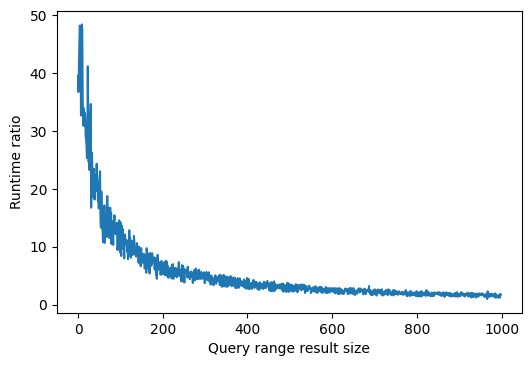

In [58]:
# Plot results
plt.plot(time_ratios)
plt.xlabel('Query range result size')
plt.ylabel('Runtime ratio')
plt.show()

For 50,000 entries, we get a performance boost of at most 50 times.

We see that the performance boost decreases as the size of the of query increases. This is expected since the more results we return the closer we get to having to iterate of all entries in the tree.

Possible additional steps:

- Implement the __iter__() method to make it iterable. With this method, users will be able to iterate over all keys using for key in kv:, where kv in an instance of KVStore.

- Implement the save() and load() method to save and load the KVStore into a file.

- Make each node keep track of the number of keys it stores in its subtree. Use that to implement a range_count() method that counts the number of entries in a range. It's possible to make this query run in O(log(n)) time.

- Implement a B+ tree to replace the underlying b-tree.